# Causal Python - PyCon2021 IL
### Based on Dr. Hanan Shteingart’s work.

## Sex Bias in Graduate Admissions: Data From Berkeley

Simpson's Paradox (Confounder Bias) Effect Estimation in 4 Ways:
1. Naive
2. Standarization
3. Regression
4. IPTW

Inspired by a Science paper:
P.J. Bickel, E.A. Hammel and J.W. O'Connell (1975). "Sex Bias in Graduate Admissions: Data From Berkeley" (PDF). Science. 187 (4175): 398–404. doi:10.1126/science.187.4175.398. PMID 17835295.

In [1]:
import pandas as pd
import numpy as np
from io import StringIO

Data from
https://raw.githubusercontent.com/hupili/python-for-data-and-media-communication-gitbook/master/assets/1973-UC-Berkeley-Admission-Data-Synthesis-Data.csv

In [2]:
dataset = """Department,Male-Admitted,Male-Denied,Female-Admitted,Female-Denied
A,512,313,89,19
B,313,207,17,8
C,101,205,202,391
D,138,279,131,244
E,40,138,94,299
F,22,351,24,317"""

df = pd.read_csv(StringIO(dataset))
df

,Department,Male-Admitted,Male-Denied,Female-Admitted,Female-Denied
0,A,512,313,89,19
1,B,313,207,17,8
2,C,101,205,202,391
3,D,138,279,131,244
4,E,40,138,94,299
5,F,22,351,24,317


In [3]:
def melt_and_duplicate(df):                                                   # Define a function to expand summary counts into one row per student
    """convert the summary stats to raw data where every row is a student"""  # Docstring: describes the transformation goal

    df_melt = df.melt(            # Reshape wide summary to long format
        id_vars='Department',     # Keep 'Department' as identifier
        var_name='group',         # Name for melted column holding group labels
        value_name='count'        # Name for melted column holding counts
    )                                                                         # End melt

    df_melt['male'] = df_melt['group'].str.contains('Male')          # Boolean: True if group label mentions 'Male'
    df_melt['admitted'] = df_melt['group'].str.contains('Admitted')  # Boolean: True if group label mentions 'Admitted'

    df_list = []                  # Collector for per-row expansions

    for i in range(len(df_melt)):                                              # Iterate each long-format row
        df_list.append(                                                        # Append expanded block for this row
            pd.concat([df_melt.iloc[[i]]] * df_melt.iloc[i]['count'], axis=0)  # Repeat the row 'count' times to create one row per student
        )                                                                      # End append

    df_raw = pd.concat(df_list, axis=0)               # Stack all expanded blocks into one DataFrame
    df_raw = df_raw.drop(['group', 'count'], axis=1)  # Remove helper columns not needed in the raw output
    return df_raw                                     # Return one-row-per-student DataFrame
    
df_raw = melt_and_duplicate(df)
df_raw

,Department,male,admitted
0,A,True,True
0,A,True,True
0,A,True,True
0,A,True,True
0,A,True,True
...,...,...,...
23,F,False,False
23,F,False,False
23,F,False,False
23,F,False,False


## Native Approach 

Mean admission for female and male
False    0.303542
True     0.429935
Name: admitted, dtype: float64

Naive ATE (effect of being male on admission): 0.1264



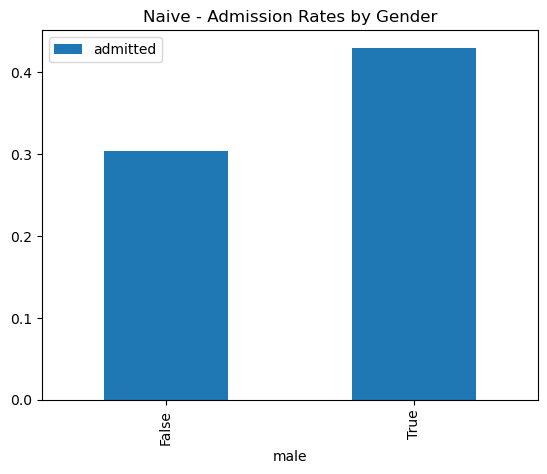

In [4]:
# Compute the naive estimate of admission rates by gender
naive_est = (df_raw
             .groupby('male')['admitted']         # Group data by gender and select the 'admitted' column
             .mean()                              # Calculate mean admission rate (proportion admitted) per group
)

# Plot the admission rates by gender as a bar chart
naive_est.plot(
    kind='bar',                                   # Use bar chart for comparison
    legend=True,                                  # Show legend (True = Male, False = Female)
    title="Naive - Admission Rates by Gender"     # Add descriptive title
)

# Compute the naive average treatment effect (ATE) of being male
naive_ate = naive_est.diff().iloc[-1]             # Difference: (Male mean - Female mean)

# Display mean admission for female and male
print("Mean admission for female and",naive_est)
print()

# Display the estimated ATE
print("Naive ATE (effect of being male on admission):", naive_ate.round(4))
print()

    Females have admission in 30%
    Males have admission in 43%

    Wrong conclusion: Bias in admission to favour males over females.

## Stantarization (Stratification)

Effect of gender on the admission: Probability of each department (p_x) and the probability of each department (p_y_x).

In [5]:
p_x = df_raw.Department.value_counts(normalize=True)
p_x.to_frame()

,proportion
Department,
A,0.209475
C,0.201841
D,0.177818
F,0.160305
E,0.128199
B,0.122362


In [6]:
p_y_x = df_raw.groupby(['Department','male'])['admitted'].mean()
p_y_x = p_y_x.reset_index(level=1)
p_y_x

,male,admitted
Department,,
A,False,0.824074
A,True,0.620606
B,False,0.680000
B,True,0.601923
C,False,0.340641
C,True,0.330065
D,False,0.349333
D,True,0.330935
E,False,0.239186


In [7]:
p_y_x['weighted'] = p_y_x['admitted'] * p_x

In [8]:
# Compute the stratified average treatment effect (ATE)

stratified_ate = (                     # Group probabilities p_y_x by gender, sum the weighted values, and take the difference
    p_y_x
    .groupby('male')['weighted']       # Group by gender and select the 'weighted' column
    .sum()                             # Sum weights (probabilities or counts)
    .diff()                            # Difference between Male and Female groups
    .iloc[-1]                          # Safely take the last difference value (Male - Female)
)

# Display the stratified ATE
print("Stratified ATE (effect of being male on admission, stratified):", stratified_ate)

Stratified ATE (effect of being male on admission, stratified): -0.06126318937738062


    Male has less probability to be admited. But it has some bias, because Gender is a confouder to application at departments.

## Regression Adjustment

In [9]:
from statsmodels.regression.linear_model import OLS
import statsmodels.formula.api as smf

In [10]:
df_raw['y'] = df_raw.admitted.astype('float')  # Create numeric outcome variable 'y' from 'admitted' (convert bool → float)

reg_model = smf.ols(                           # Build an OLS regression model
    formula='y ~ male + C(Department)',        # Model: admission ~ gender + department fixed effects
    data=df_raw.reset_index()                  # Reset index for compatibility with patsy (formula parser)
).fit()                                        # Fit the regression model to the data

reg_ate = reg_model.params['male[T.True]']     # Extract coefficient for 'male' (interpreted as the ATE of being male)

reg_model.summary()                            # Display full regression results (coefficients, R², p-values, etc.)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     153.9
Date:                Thu, 21 Aug 2025   Prob (F-statistic):          4.25e-178
Time:                        10:02:28   Log-Likelihood:                -2675.4
No. Observations:                4454   AIC:                             5365.
Df Residuals:                    4447   BIC:                             5410.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6775      0.020     34.086      0.000       0.639       0.716
male[T.True]          -0.0377      0.015     -2.442      0.015      -0.068      -0.007
C(Department)[T.B]    -0.0360      0.024     -1.512      0.131      -0.083       0.011
C(Department)[T.C]    -0.3276      0.022    -14.707      0.000      -0.371      -0.284
C(Department)[T.D]    -0.3180      0.022    -14.431      0.000      -0.361      -0.275
C(Department)[T.E]    -0.4310      0.025    -17.195      0.000      -0.480      -0.382
C(Department)[T.F]    -0.5934      0.023    -26.193      0.000      -0.638      -0.549
==============================================================================
Omnibus:                     2839.241   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.503
Skew:                           0.328   Prob(JB):                     1.71e-72
Kurtosis:                       1.838   Cond. No.                         8.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
print(reg_ate.round(4))

-0.0377


    Again, the probability of a male be admited is smaller than if is a female.

## IPTW

First, we consider the probability of being male given the confounder, i.e., the probability of an individual being male or female given the department.

In [12]:
df_raw['male_float'] = df_raw['male'].astype('float')            # Convert 'male' boolean to float (0.0 = Female, 1.0 = Male)

propensity_model = smf.ols(                                      # Build a linear probability model for propensity scores
    formula='male_float ~ C(Department)',                        # Predict gender (male) from department categories
    data=df_raw.reset_index()                                    # Reset index for compatibility with patsy formulas
).fit()                                                          # Fit the propensity score model

p = propensity_model.get_prediction().predicted_mean             # Get predicted probabilities (propensity scores) for being male

iptw_ate = (                                                     # Compute Inverse Probability of Treatment Weighting (IPTW) estimate
    (df_raw['admitted'] * (df_raw['male'] - p) / (p * (1 - p)))  # Weight outcomes by inverse propensity of treatment assignment
    .mean()                                                      # Average across all observations → ATE estimate
)

## Summary

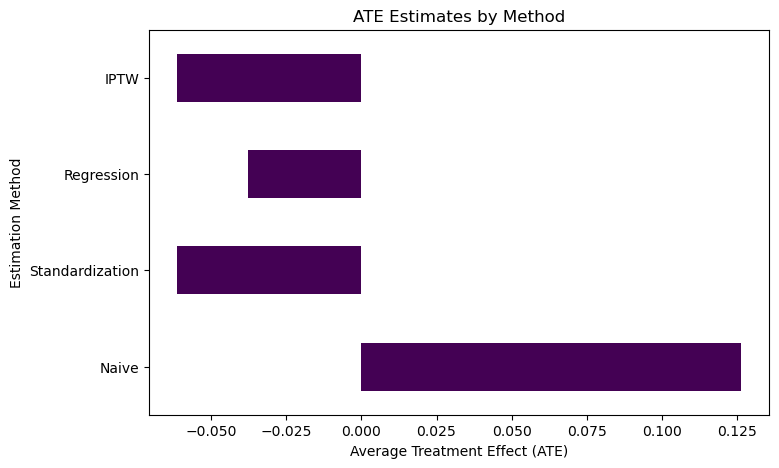

In [13]:
# Create a comparison table of ATE estimates from different methods
ate_results = pd.DataFrame({
    'method': ['Naive', 'Standardization', 'Regression', 'IPTW'], # Names of estimation methods
    'ATE':    [naive_ate, stratified_ate, reg_ate, iptw_ate]      # Corresponding ATE values
})

# Plot the results as a horizontal bar chart
(ate_results
    .set_index('method')                          # Use 'method' column as index for clearer labeling
    .plot(
        kind='barh',                              # Horizontal bar chart
        legend=False,                             # No legend needed (methods are already labels on y-axis)
        title="ATE Estimates by Method",          # Add descriptive title
        xlabel="Average Treatment Effect (ATE)",  # Label x-axis
        ylabel="Estimation Method",               # Label y-axis
        figsize=(8, 5),                           # Set figure size for readability
        colormap="viridis"                        # Use a visually appealing colormap
    )
);

    At a naive approach, it appears that males are more likely to be admitted, but when you take the confounder (the department) into account, being male reduces your chance of being admitted.